# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
def initBump(data_args, dataShape, d_shift=1e6,D=0.5*1e6):

    eta0  = np.zeros(dataShape, dtype=np.float32, order='C')
    hu0   = np.zeros(dataShape, dtype=np.float32, order='C')
    hv0   = np.zeros(dataShape, dtype=np.float32, order='C')

    x_center = data_args["dx"]*(data_args["nx"]+4)*0.5
    y_center = data_args["dy"]*(data_args["ny"]+4)*0.5

    scale = 1e9
    for j in range(data_args["ny"] + 4):
        for i in range(data_args["nx"] + 4):
            x = data_args["dx"]*i - x_center
            y = data_args["dy"]*j - y_center

            d = np.sqrt(x**2 + y**2)
            
            eta0[j, i] += 0.1*(1.0+np.tanh(-(d-d_shift)/D))

    return eta0, hu0, hv0

In [5]:
def initLevel(l):
    data_args = {}
    data_args["nx"] = 2**l
    data_args["ny"] = 2**l 
    dataShape = (data_args["ny"] + 4, data_args["nx"] + 4)

    data_args["dx"] = 2**(19-l)*100
    data_args["dy"] = 2**(19-l)*100

    data_args["dt"] = 0.0
    data_args["g"] = 9.81
    data_args["f"] = 1.2e-4
    data_args["r"] = 0.0
    # data_args["boundary_conditions"] = Common.BoundaryConditions(1,1,1,1)

    data_args["eta0"], data_args["hu0"], data_args["hv0"] = initBump(data_args, dataShape)
    
    H0 = 1000.0
    data_args["H"] = np.ma.array(np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')*H0, mask=False)

    return data_args

In [6]:
def wind_bump(ny, nx, sig = None):
    dataShape = (ny, nx )
    w = np.zeros(dataShape, dtype=np.float32, order='C')

    x_center = 0.5*nx
    y_center = 0.5*ny

    if sig is None:
        sig = nx**2/10

    for j in range(ny):
        for i in range(nx):
            x = i - x_center
            y = j - y_center

            d = x**2 + y**2
            
            w[j, i] = np.exp(-1/2*d/sig)    
    
    return w


In [7]:
def KL_perturbations(t_splits, KL_N):
    # Sampling random field based on Karhunen-Loeve expansions
    
    # t_splits (int) - number of how many KL-fields are generated

    # Output: size=(t_splits, N, N) with t_splits-times a KL-field

    KL_DECAY=1.05
    KL_SCALING=0.15

    KL_fields = np.zeros((t_splits,KL_N,KL_N))

    rns = np.random.normal(size=(10,10,t_splits))

    for n in range(1, rns.shape[1]+1):
        for m in range(1, rns.shape[0]+1):
            KL_fields += np.tile(KL_SCALING * m**(-KL_DECAY) * n**(-KL_DECAY) * np.outer(np.sin(m*np.pi*np.linspace(0,1,KL_N)), np.sin(n*np.pi*np.linspace(0,1,KL_N))), (t_splits,1,1)) * rns[m-1, n-1][:,np.newaxis,np.newaxis]

    return KL_fields

In [8]:
def wind_sample(wind_N, t_splits, wind_speed=5.0):
    ## KL perturbed wind fields (much faster!)
        
    wind_degree = np.deg2rad(np.random.uniform(0,360))

    init_wind_u = wind_speed * np.sin(wind_degree) * np.ones((wind_N,wind_N))
    init_wind_v = wind_speed * np.cos(wind_degree) * np.ones((wind_N,wind_N))

    KL_fields_u = KL_perturbations(t_splits, wind_N)
    KL_fields_v = KL_perturbations(t_splits, wind_N)

    wind_u = np.repeat(init_wind_u[np.newaxis,:,:], t_splits, axis=0) + np.cumsum(KL_fields_u, axis=0)
    wind_v = np.repeat(init_wind_v[np.newaxis,:,:], t_splits, axis=0) + np.cumsum(KL_fields_v, axis=0)

    wind_weight = wind_bump(wind_N,wind_N)

    wind_u = wind_u *np.repeat(wind_weight[np.newaxis,:,:], t_splits, axis=0)
    wind_v = wind_v *np.repeat(wind_weight[np.newaxis,:,:], t_splits, axis=0)

    ts = np.linspace(0,250000,t_splits)

    return WindStress.WindStress(t=ts, wind_u=wind_u.astype(np.float32), wind_v=wind_v.astype(np.float32))

In [9]:
wind_N = 100
t_splits = 251

## Data Assimilation

In [10]:
def imshow3(etahuhv):
    fig, axs = plt.subplots(1,3, figsize=(15,10))
    im = axs[0].imshow(etahuhv[0], vmin=-0.05, vmax=0.05, cmap="coolwarm")
    plt.colorbar(im, ax=axs[0], shrink=0.5)

    im = axs[1].imshow(etahuhv[1], vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(im, ax=axs[1], shrink=0.5)

    im = axs[2].imshow(etahuhv[2], vmin=-1, vmax=1, cmap="coolwarm")
    plt.colorbar(im, ax=axs[2], shrink=0.5)

    return fig, axs

In [11]:
ls = [6, 7, 8, 9, 10]

### Truth

In [12]:
data_args = initLevel(ls[-1])
true_wind = wind_sample(wind_N, t_splits)
truth = CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=true_wind)
truth.step(250000)

250000.0

In [13]:
true_eta, true_hu, true_hv = truth.download(interior_domain_only=True)

In [111]:
Hfield = np.zeros((truth.ny,truth.nx))
Hy, Hx = 600, 400
Hfield[Hy,Hx] = 1.0

R = [0.0001, 0.01, 0.01]

obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)

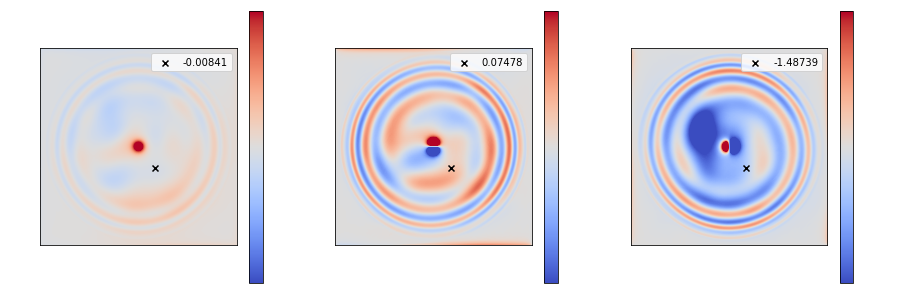

In [112]:
fig, axs = imshow3([true_eta, true_hu, true_hv])
axs[0].scatter(Hy, Hx, marker="x", c="black", label=str(round(obs[0],5)))
axs[0].legend(labelcolor="black")
axs[1].scatter(Hy, Hx, marker="x", c="black", label=str(round(obs[1],5)))
axs[1].legend(labelcolor="black")
axs[2].scatter(Hy, Hx, marker="x", c="black", label=str(round(obs[2],5)))
axs[2].legend(labelcolor="black")

In [114]:
plt.rcParams["image.origin"]

'lower'

In [113]:
print("HERE IS SOME X/Y-MESS HAPPENING!!!")

HERE IS SOME X/Y-MESS HAPPENING!!!


### Ensemble

In [16]:
Nes = [100, 75, 50, 25, 10]

In [17]:
ensemble = []

lvl_ensemble = []
data_args = initLevel(ls[0])
for e in range(Nes[0]):
    t_splits = 251

    wind = wind_sample(wind_N, t_splits)

    lvl_ensemble.append(CDKLM16.CDKLM16(gpu_ctx, **data_args, wind=wind))

ensemble.append(lvl_ensemble)
    

for l_idx in range(1,len(Nes)):
    lvl_ensemble0 = []
    lvl_ensemble1 = []
    
    data_args0 = initLevel(ls[l_idx])
    data_args1 = initLevel(ls[l_idx-1])
    
    for e in range(Nes[l_idx]):
        t_splits = 251

        wind = wind_sample(wind_N, t_splits)
        
        lvl_ensemble0.append(CDKLM16.CDKLM16(gpu_ctx, **data_args0, wind=wind))
        lvl_ensemble1.append(CDKLM16.CDKLM16(gpu_ctx, **data_args1, wind=wind))
    
    ensemble.append([lvl_ensemble0,lvl_ensemble1])

In [18]:
for e in range(Nes[0]):
    ensemble[0][e].step(250000)
    
for l_idx in range(1,len(Nes)):
    for e in range(Nes[l_idx]):
        ensemble[l_idx][0][e].step(250000)
        ensemble[l_idx][1][e].step(250000)

In [97]:
state = []

lvl_state = []
for e in range(Nes[0]):
    eta, hu, hv = ensemble[0][e].download(interior_domain_only=True)
    lvl_state.append(np.array([eta, hu, hv]))
state.append(np.array(lvl_state))
state[0] = np.moveaxis(state[0], 0, -1)

for l_idx in range(1,len(Nes)):
    lvl_state0 = []
    lvl_state1 = []
    for e in range(Nes[l_idx]):
        eta0, hu0, hv0 = ensemble[l_idx][0][e].download(interior_domain_only=True)
        eta1, hu1, hv1 = ensemble[l_idx][1][e].download(interior_domain_only=True)
        lvl_state0.append(np.array([eta0, hu0, hv0]))
        lvl_state1.append(np.array([eta1, hu1, hv1]))
    state.append([np.array(lvl_state0), np.array(lvl_state1)])
    state[l_idx][0] = np.moveaxis(state[l_idx][0], 0, -1)
    state[l_idx][1] = np.moveaxis(state[l_idx][1], 0, -1)

In [98]:
def MLmean(state):
    MLest_mean = np.zeros((3,2**ls[-1],2**ls[-1]))
    MLest_mean += np.average(state[0], axis=-1).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2)

    for l_idx, l in enumerate(ls):
        if l_idx > 0: 
            MLest_mean += np.average(state[l_idx][0] - state[l_idx][1].repeat(2,1).repeat(2,2), axis=-1).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2)

    return MLest_mean

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

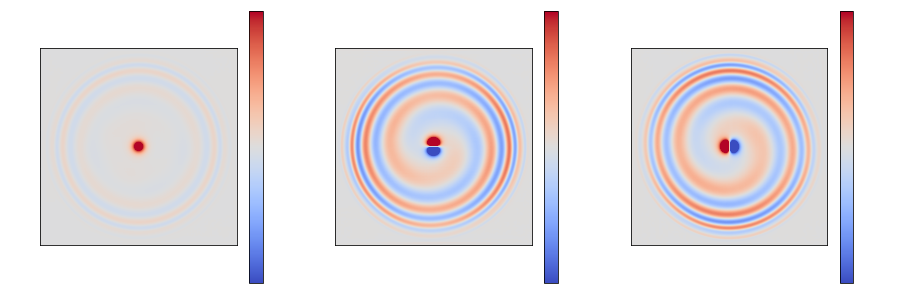

In [99]:
MLest_mean = MLmean(state)
imshow3(MLest_mean)

### Kalman gain

In [100]:
perts = []
for l_idx in range(len(ls)):
    perts.append(np.random.multivariate_normal(np.zeros(3), np.diag(R), size=Nes[l_idx]))

In [101]:
Xs = np.linspace(0, ensemble[-1][0][0].nx * ensemble[-1][0][0].dx, ensemble[-1][0][0].nx)
Ys = np.linspace(0, ensemble[-1][0][0].ny * ensemble[-1][0][0].dy, ensemble[-1][0][0].ny)
Y, X = np.meshgrid(Ys, Xs)

obs_loc = np.zeros(2)
obs_loc[0] = X[Hx,0]
obs_loc[1] = Y[0,Hy]
dists = np.sqrt((X - obs_loc[0])**2 + (Y - obs_loc[1])**2)

r = 1e7

GC = np.zeros_like(dists)
for i in range(dists.shape[0]):
    for j in range(dists.shape[1]):
        dist = dists[i,j]
        if dist/r < 1: 
            GC[i,j] = 1 - 5/3*(dist/r)**2 + 5/8*(dist/r)**3 + 1/2*(dist/r)**4 - 1/4*(dist/r)**5
        elif dist/r >= 1 and dist/r < 2:
            GC[i,j] = 4 - 5*(dist/r) + 5/3*(dist/r)**2 + 5/8*(dist/r)**3 -1/2*(dist/r)**4 + 1/12*(dist/r)**5 - 2/(3*(dist/r))

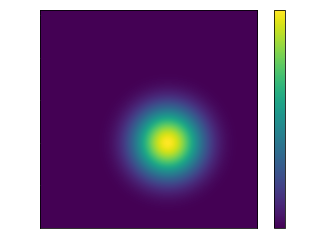

In [102]:
plt.imshow(GC)
plt.colorbar()

In [103]:
from skimage.measure import block_reduce

In [104]:
ML_XY = np.zeros((3*(2**ls[-1])**2,3))

In [105]:
lvl_Xs = np.linspace(0, ensemble[0][0].nx * ensemble[0][0].dx, ensemble[0][0].nx)
lvl_Ys = np.linspace(0, ensemble[0][0].ny * ensemble[0][0].dy, ensemble[0][0].ny)
lvl_Y, lvl_X = np.meshgrid(lvl_Ys, lvl_Xs)

obs_idxs = np.unravel_index(np.argmin(((lvl_X - X[Hx,0])**2 + (lvl_Y - Y[0,Hy])**2).T), (2**ls[0],2**ls[0]))

X0 = state[0]
X0mean = np.average(X0, axis=-1)

Y0 = state[0][:,obs_idxs[0],obs_idxs[1]] + perts[0].T
Y0mean = np.average(Y0, axis=-1)

lvl_weight = np.ones(3*(2**ls[0])**2)

ML_XY += (lvl_weight[:,np.newaxis]*1/Nes[0]*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T)).reshape(X0mean.shape + (3,)).repeat(2**(ls[-1]-ls[0]),1).repeat(2**(ls[-1]-ls[0]),2).reshape(-1,ML_XY.shape[-1])

In [106]:
for l_idx in range(1,len(ls)):
    l = ls[l_idx]

    lvl_Xs0 = np.linspace(0, ensemble[l_idx][0][0].nx * ensemble[l_idx][0][0].dx, ensemble[l_idx][0][0].nx)
    lvl_Ys0 = np.linspace(0, ensemble[l_idx][0][0].ny * ensemble[l_idx][0][0].dy, ensemble[l_idx][0][0].ny)
    lvl_Y0, lvl_X0 = np.meshgrid(lvl_Ys0, lvl_Xs0)
    obs_idxs0 = np.unravel_index(np.argmin(((lvl_X0 - X[Hx,0])**2 + (lvl_Y0 - Y[0,Hy])**2).T), (2**l,2**l))

    lvl_Xs1 = np.linspace(0, ensemble[l_idx][1][0].nx * ensemble[l_idx][1][0].dx, ensemble[l_idx][1][0].nx)
    lvl_Ys1 = np.linspace(0, ensemble[l_idx][1][0].ny * ensemble[l_idx][1][0].dy, ensemble[l_idx][1][0].ny)
    lvl_Y1, lvl_X1 = np.meshgrid(lvl_Ys1, lvl_Xs1)
    obs_idxs1 = np.unravel_index(np.argmin(((lvl_X1 - X[Hx,0])**2 + (lvl_Y1 - Y[0,Hy])**2).T), (2**(l-1),2**(l-1)))

    X0 = state[l_idx][0]
    X0mean = np.average(X0, axis=-1)
    X1 = state[l_idx][1].repeat(2,1).repeat(2,2)
    X1mean = np.average(X1, axis=-1)

    Y0 = state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1]] + perts[l_idx].T
    Y0mean = np.average(Y0, axis=-1)
    Y1 = state[l_idx][1][:,obs_idxs1[0],obs_idxs1[1]] + perts[l_idx].T
    Y1mean = np.average(Y1, axis=-1)

    lvl_weight = np.tile(block_reduce(GC, block_size=(2**(ls[-1]-l),2**(ls[-1]-l)), func=np.mean).flatten(),3)

    ML_XY += (lvl_weight[:,np.newaxis] * ( 1/Nes[l_idx]*((X0-X0mean[:,:,:,np.newaxis]).reshape(-1,X0.shape[-1]) @ (Y0 - Y0mean[:,np.newaxis]).T) - 1/Nes[l_idx]*((X1-X1mean[:,:,:,np.newaxis]).reshape(-1,X1.shape[-1]) @ (Y1 - Y1mean[:,np.newaxis]).T) )).reshape(X0mean.shape + (3,)).repeat(2**(ls[-1]-l),1).repeat(2**(ls[-1]-l),2).reshape(-1,ML_XY.shape[-1])


In [107]:
ML_HXY = ML_XY.reshape(3,2**ls[-1],2**ls[-1],3)[:,obs_idxs0[0],obs_idxs0[1],:]
ML_YY  = ML_HXY + np.diag(R)

ML_K = ML_XY @ np.linalg.inv(ML_YY)

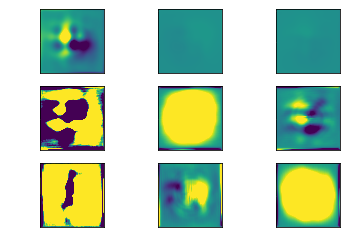

In [108]:
ML_K_field = ML_K.reshape(3,2**ls[-1],2**ls[-1],3)

fig, axs = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        axs[i,j].imshow(ML_K_field[i,:,:,j], vmin=-0.1,vmax=0.1)

### Update

In [109]:
lvl_Xs = np.linspace(0, ensemble[0][0].nx * ensemble[0][0].dx, ensemble[0][0].nx)
lvl_Ys = np.linspace(0, ensemble[0][0].ny * ensemble[0][0].dy, ensemble[0][0].ny)
lvl_Y, lvl_X = np.meshgrid(lvl_Ys, lvl_Xs)

obs_idxs = np.unravel_index(np.argmin(((lvl_X - X[Hx,0])**2 + (lvl_Y - Y[0,Hy])**2).T), (2**ls[0],2**ls[0]))

state[0] = state[0] + block_reduce((ML_K @ (obs[:,np.newaxis] - state[0][:,obs_idxs[0],obs_idxs[1]] - perts[0].T)).reshape(3,2**ls[-1],2**ls[-1],Nes[0]), block_size=(1,2**(ls[-1]-ls[0]), 2**(ls[-1]-ls[0]), 1), func=np.mean)

for l_idx in range(1,len(ls)):
    l = ls[l_idx]

    lvl_Xs0 = np.linspace(0, ensemble[l_idx][0][0].nx * ensemble[l_idx][0][0].dx, ensemble[l_idx][0][0].nx)
    lvl_Ys0 = np.linspace(0, ensemble[l_idx][0][0].ny * ensemble[l_idx][0][0].dy, ensemble[l_idx][0][0].ny)
    lvl_Y0, lvl_X0 = np.meshgrid(lvl_Ys0, lvl_Xs0)
    obs_idxs0 = np.unravel_index(np.argmin(((lvl_X0 - X[Hx,0])**2 + (lvl_Y0 - Y[0,Hy])**2).T), (2**l,2**l))

    lvl_Xs1 = np.linspace(0, ensemble[l_idx][1][0].nx * ensemble[l_idx][1][0].dx, ensemble[l_idx][1][0].nx)
    lvl_Ys1 = np.linspace(0, ensemble[l_idx][1][0].ny * ensemble[l_idx][1][0].dy, ensemble[l_idx][1][0].ny)
    lvl_Y1, lvl_X1 = np.meshgrid(lvl_Ys1, lvl_Xs1)
    obs_idxs1 = np.unravel_index(np.argmin(((lvl_X1 - X[Hx,0])**2 + (lvl_Y1 - Y[0,Hy])**2).T), (2**(l-1),2**(l-1)))

    state[l_idx][0] = state[l_idx][0] + block_reduce((ML_K @ (obs[:,np.newaxis] - state[l_idx][0][:,obs_idxs0[0],obs_idxs0[1]] - perts[l_idx].T)).reshape(3,2**ls[-1],2**ls[-1],Nes[l_idx]), block_size=(1,2**(ls[-1]-l), 2**(ls[-1]-l), 1), func=np.mean)
    state[l_idx][1] = state[l_idx][1] + block_reduce((ML_K @ (obs[:,np.newaxis] - state[l_idx][1][:,obs_idxs1[0],obs_idxs1[1]] - perts[l_idx].T)).reshape(3,2**ls[-1],2**ls[-1],Nes[l_idx]), block_size=(1,2**(ls[-1]-l+1), 2**(ls[-1]-l+1), 1), func=np.mean)

(<Figure size 1080x720 with 6 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

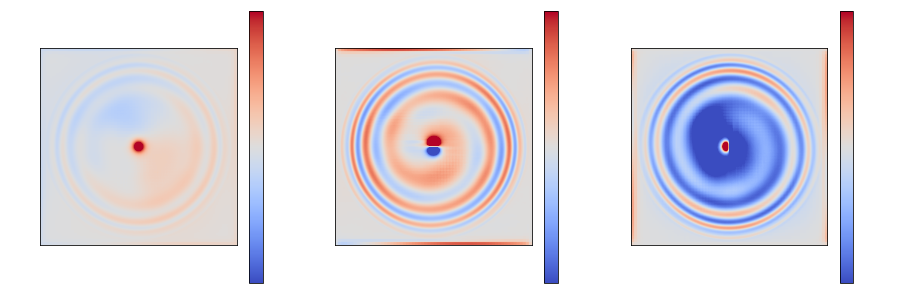

In [110]:
MLest_mean = MLmean(state)
imshow3(MLest_mean)